In [1]:
import spconv.pytorch as spconv
from spconv.pytorch.utils import PointToVoxel
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from spconv.pytorch.hash import HashTable
import scipy


In [2]:
input_size=[32,32]
num_samples=1
sparsity=0.05
seed=2
r = np.random.default_rng(seed=seed)
size = tuple([num_samples] + input_size)
_mask = r.random(size=size) < sparsity
_mask = scipy.ndimage.binary_dilation(_mask[0], iterations=1, structure=np.ones((3,3)))[np.newaxis,...]

mask = torch.tensor(_mask).to_sparse()#.coalesce()
# indices = mask.indices().permute(1,0)[:,[0,3,2,1]].type(torch.int32)
indices = mask.indices().permute(1,0).type(torch.int32).contiguous()
features = r.random(size=(len(indices),1))
features = np.ones_like(features)
features = torch.tensor(features).float()

In [11]:
x = spconv.SparseConvTensor(features.cuda(), indices.cuda(), input_size, num_samples)

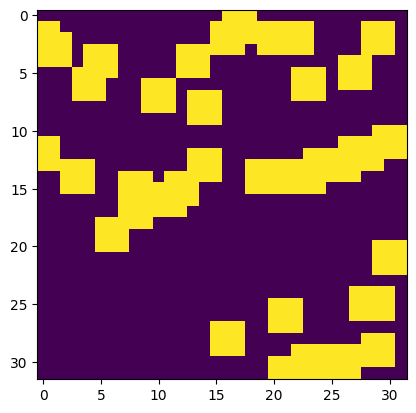

In [4]:
plt.imshow(_mask[0])
plt.show()

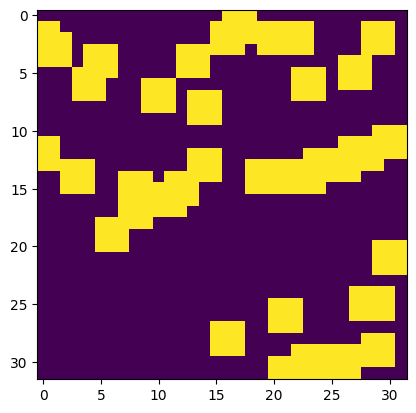

In [6]:
plt.imshow(x.dense()[0,0].detach().cpu().numpy())
plt.show()

In [12]:
conv = spconv.SparseConv2d(in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=0)
nn.init.constant_(conv.weight, 1.)
nn.init.constant_(conv.bias, 0.)
conv = conv.cuda()
z = conv(x)
len(z.indices), len(x.indices)

(599, 287)

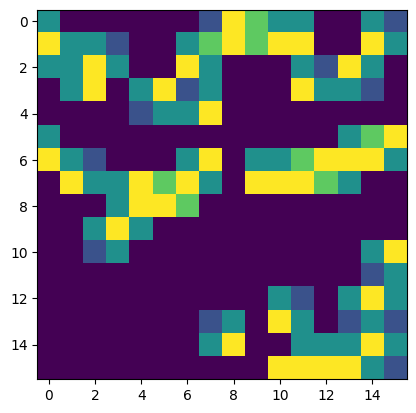

In [41]:
plt.imshow(z.dense()[0,0].detach().cpu().numpy())
plt.show()

In [13]:
z.indices.max(dim=0)

torch.return_types.max(
values=tensor([ 0, 27, 27], device='cuda:0', dtype=torch.int32),
indices=tensor([ 0, 25, 13], device='cuda:0'))

In [7]:
from torch import nn
class ExampleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = spconv.SparseSequential(
            spconv.SubMConv3d(1, 64, 3, stride=2, indice_key="0"), # just like nn.Conv3d but don't support group
            nn.BatchNorm1d(64), # non-spatial layers can be used directly in SparseSequential.
            nn.ReLU(),)
        self.b2 = spconv.SparseSequential(
            spconv.SparseConv3d(64, 64, 3, indice_key="1"),
            nn.BatchNorm1d(64),
            nn.ReLU(),)
            # when use submanifold convolutions, their indices can be shared to save indices generation time.
        self.b3 = spconv.SparseSequential(
            spconv.SubMConv3d(64, 64, 3, indice_key="2"),
            nn.BatchNorm1d(64),
            nn.ReLU(),)
        self.b4 = spconv.SparseSequential(
            spconv.SparseConv3d(64, 64, 3, stride=2, indice_key="3"), # just like nn.Conv3d but don't support group
            nn.BatchNorm1d(64), # non-spatial layers can be used directly in SparseSequential.
            nn.ReLU(),)
        self.b5 = spconv.SparseSequential(
            spconv.SparseInverseConv3d(64, 64, 3, indice_key="3"),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            spconv.SparseIdentity())
        
            # spconv.ToDense(), # convert spconv tensor to dense and convert it to NCHW format.
            # nn.Conv3d(64, 64, 3),
            # nn.BatchNorm1d(64),
            # nn.ReLU(),

    def forward(self, x):
        print(x.indices[:6])
        x = self.b1(x)
        print(x.indices[:6])
        x = self.b2(x)
        print(x.indices[:6])
        x = self.b3(x)
        print(x.indices[:6])
        x = self.b4(x)
        print(x.indices[:6])
        x = self.b5(x)
        print(x.indices[:6])
        return x

In [77]:
model = ExampleNet()
model.eval()
model.cuda()

ExampleNet(
  (b1): SparseSequential(
    (0): SubMConv3d(1, 64, kernel_size=[3, 3, 3], stride=[2, 2, 2], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.MaskImplicitGemm)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (b2): SparseSequential(
    (0): SparseConv3d(64, 64, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.MaskImplicitGemm)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (b3): SparseSequential(
    (0): SubMConv3d(64, 64, kernel_size=[3, 3, 3], stride=[1, 1, 1], padding=[0, 0, 0], dilation=[1, 1, 1], output_padding=[0, 0, 0], algo=ConvAlgo.MaskImplicitGemm)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (b4): SparseSequential(
    (0): SparseConv3d(64, 64, kernel_size=[3, 3, 3], strid

In [78]:
with torch.no_grad():
    out = model(x)

tensor([[ 0,  0,  0, 11],
        [ 0,  0,  1, 54],
        [ 0,  0,  2,  4],
        [ 0,  0,  2, 77],
        [ 0,  0,  4, 19],
        [ 0,  0,  6, 24]], device='cuda:0', dtype=torch.int32)
tensor([[ 0,  0,  0, 11],
        [ 0,  0,  1, 54],
        [ 0,  0,  2,  4],
        [ 0,  0,  2, 77],
        [ 0,  0,  4, 19],
        [ 0,  0,  6, 24]], device='cuda:0', dtype=torch.int32)
tensor([[11, 69, 49, 58],
        [ 9, 71, 69, 72],
        [ 8, 14, 22, 34],
        [ 0, 23,  4, 16],
        [ 4, 13, 48, 72],
        [ 5, 79, 26, 38]], device='cuda:0', dtype=torch.int32)
tensor([[11, 69, 49, 58],
        [ 9, 71, 69, 72],
        [ 8, 14, 22, 34],
        [ 0, 23,  4, 16],
        [ 4, 13, 48, 72],
        [ 5, 79, 26, 38]], device='cuda:0', dtype=torch.int32)
tensor([[ 0, 25, 25, 40],
        [11, 11,  2, 15],
        [ 2,  6, 27, 31],
        [14,  6, 11, 22],
        [12,  4,  5,  6],
        [ 7, 26, 44, 27]], device='cuda:0', dtype=torch.int32)
tensor([[11, 69, 49, 58],
        [

In [79]:
out.features.shape, out.indices.shape, out.indice_dict

(torch.Size([154740, 64]),
 torch.Size([154740, 4]),
 {'0': <spconv.pytorch.core.ImplicitGemmIndiceData at 0x7f82e84649a0>,
  '1': <spconv.pytorch.core.ImplicitGemmIndiceData at 0x7f82e8244790>,
  '2': <spconv.pytorch.core.ImplicitGemmIndiceData at 0x7f82e8244eb0>,
  '3': <spconv.pytorch.core.ImplicitGemmIndiceData at 0x7f82e8244880>})

In [16]:
dir(out)

['__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_features',
 '_timer',
 'batch_size',
 'benchmark',
 'benchmark_record',
 'dense',
 'dequantize',
 'features',
 'find_indice_pair',
 'force_algo',
 'from_dense',
 'grid',
 'indice_dict',
 'indices',
 'int8_scale',
 'is_quantized',
 'minus',
 'q_scale',
 'replace_feature',
 'select_by_index',
 'shadow_copy',
 'spatial_shape',
 'spatial_size',
 'thrust_allocator',
 'voxel_num']

In [17]:
out.spatial_shape, out.spatial_size

([189, 189, 189], 6751269)